# Import Libraries

In [ ]:
import os      
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16, VGG19
#from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as mat
import argparse
import Augmentor
import cv2
import os
import pandas as pd
import shutil
import random
from sklearn.cluster import KMeans
from sklearn import metrics 
from scipy.spatial.distance import cdist
from imutils import paths
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import shutil
import cv2
import os

## Download datasets

In [2]:
normal = 'NORMAL'
PNEUMONIA = 'PNEUMONIA'
covid = 'COVID'
# Path list
dir_normal = os.listdir(normal)
dir_PNEUMONIA = os.listdir(PNEUMONIA)
dir_covid = os.listdir(covid)

## Plot normal, PNEUMONIA and COVID chest X-ray images

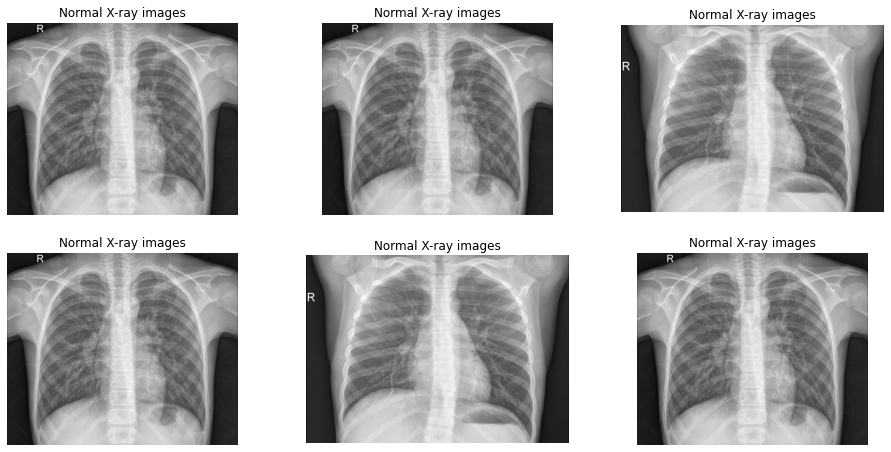

In [4]:
mat.figure(figsize=(16,12))
for i in range(6):
    ran = random.choice((1,30))
    normal1 = [os.path.join(normal, f) for f in dir_normal[ran:ran+1]]
    rand = random.choice(normal1)
    mat.subplot(3, 3, i+1)
    img = mat.imread(rand)
    mat.imshow(img,cmap = 'gray')
    mat.axis(False)
    mat.title('Normal X-ray images')
mat.show()

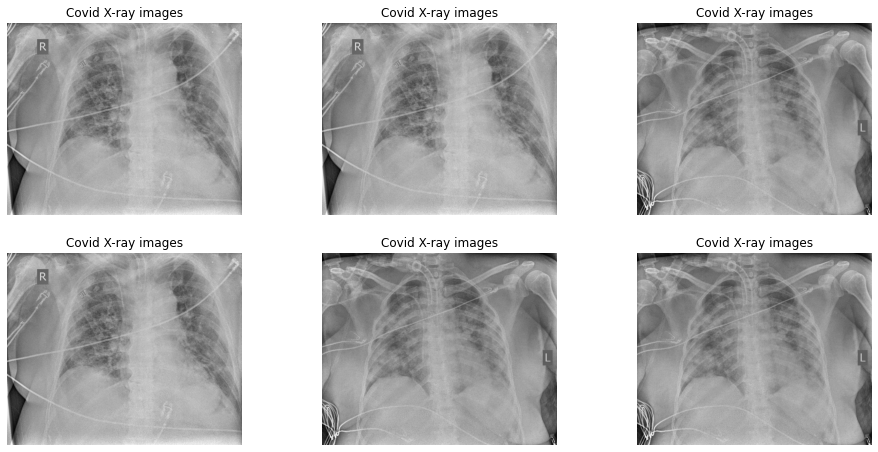

In [5]:
mat.figure(figsize=(16,12))
for i in range(6):
    ran = random.choice((1,30))
    covid1 = [os.path.join(covid, f) for f in dir_covid[ran:ran+1]]
    rand = random.choice(covid1)
    mat.subplot(3, 3, i+1)
    img = mat.imread(rand)
    mat.imshow(img,cmap = 'gray')
    mat.axis(False)
    mat.title('Covid X-ray images')
mat.show()

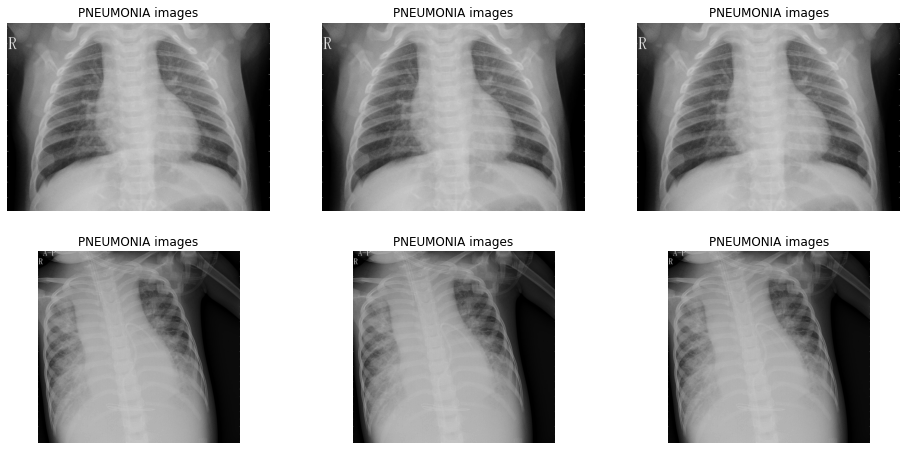

In [6]:
mat.figure(figsize=(16,12))
for i in range(6):
    ran = random.choice((1,30))
    covid1 = [os.path.join(PNEUMONIA, f) for f in dir_PNEUMONIA[ran:ran+1]]
    rand = random.choice(covid1)
    mat.subplot(3, 3, i+1)
    img = mat.imread(rand)
    mat.imshow(img,cmap = 'gray')
    mat.axis(False)
    mat.title('PNEUMONIA images')
mat.show()

## Covid images augmentation

In [ ]:
x = Augmentor.Pipeline("COVID")
x.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
x.random_distortion(probability=1, grid_width=4, grid_height=4, magnitude=8)
x.flip_left_right(probability=1)
x.process()  
x.sample(580) #generate 580 augmented images based on your specifications

## Image Preprocessing

In [3]:
imagePaths = list(paths.list_images(normal))
data = []
labels = []
for imagePath in imagePaths:
    label = 0
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)
data = np.array(data) /255
labels = np.array(labels)

In [5]:
imagePaths1 = list(paths.list_images(covid))
data1 = []
labels1 = []
for imagePath in imagePaths1:
    label1 = 1
    # 224x224 pixels while ignoring aspect ratio
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data1.append(image)
    labels1.append(label1)

data1 = np.array(data1) / 255
labels1 = np.array(labels1)

In [7]:
imagePaths2 = list(paths.list_images(PNEUMONIA))
data2 = []
labels2 = []
for imagePath in imagePaths2:
    label2 = 2
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    data2.append(image)
    labels2.append(label2)
data2 = np.array(data2) / 255
labels2 = np.array(labels2)

In [9]:
dataset = np.concatenate((data, data1, data2), axis=0)
label = np.concatenate((labels, labels1, labels2), axis=0)

In [10]:
label = to_categorical(label)
label

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

## Train and Test split

In [11]:
(trainX, testX, trainY, testY) = train_test_split(dataset, label, test_size=0.20, stratify=label, random_state=42)
(trainX, valX, trainY, valY) = train_test_split(trainX, trainY, test_size=0.20, random_state=42)

In [12]:
testY

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]], dtype=float32)

## Build the models

## Remove the # from the BaseModel to run the model you want. We have three models
### 1- DenseNet201 model
### 2- VGG16 model
### 3- VGG19  model

In [18]:
# initialize the initial learning rate, number of epochs, and batch size
INIT_LR = 1e-3
EPOCHS = 15
BS = 8
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
#baseModel = VGG19(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))
#baseModel = DenseNet201(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

callbacks = [EarlyStopping(monitor='val_loss', patience=8),ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
# compile our model
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the head of the network
H = model.fit(trainX, trainY, validation_data=(valX,valY),batch_size = BS, epochs=EPOCHS,callbacks=callbacks)

In [ ]:
acc = H.history['acc']
loss = H.history['loss']
val_loss = H.history['val_loss']
val_acc = H.history['val_acc']
epochs = range(len(H.epoch))

title1 = 'Accuracy vs Validation Accuracy'
leg1 = ['Acc', 'Val_acc']
title2 = 'Loss vs Val_loss'
leg2 = ['Loss', 'Val_loss']

def plot(epochs, acc, val_acc, leg, title):
    mat.plot(epochs, acc)
    mat.plot(epochs, val_acc)
    mat.title(title)
    mat.legend(leg)
    mat.xlabel('epochs')

mat.figure(figsize=(15,5))
mat.subplot(1,2,1)
plot(epochs, acc, val_acc, leg1, title1)
mat.subplot(1,2,2)
plot(epochs, loss, val_loss, leg2, title2)
mat.show()

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,digits=4))

In [ ]:
# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
import seaborn as sns
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
sns.set(font_scale=1)#for label size
sns.heatmap(cm, cmap="Blues", annot=True,annot_kws={"size": 12})# font siz
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.figure(figsize = (16,12))
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
# show the confusion matrix, accuracy, sensitivity, and specificity
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

Total-test-data; 2456 	accurately-predicted-data: 2345 	 wrongly-predicted-data:  111
Accuracy: 95.48 %


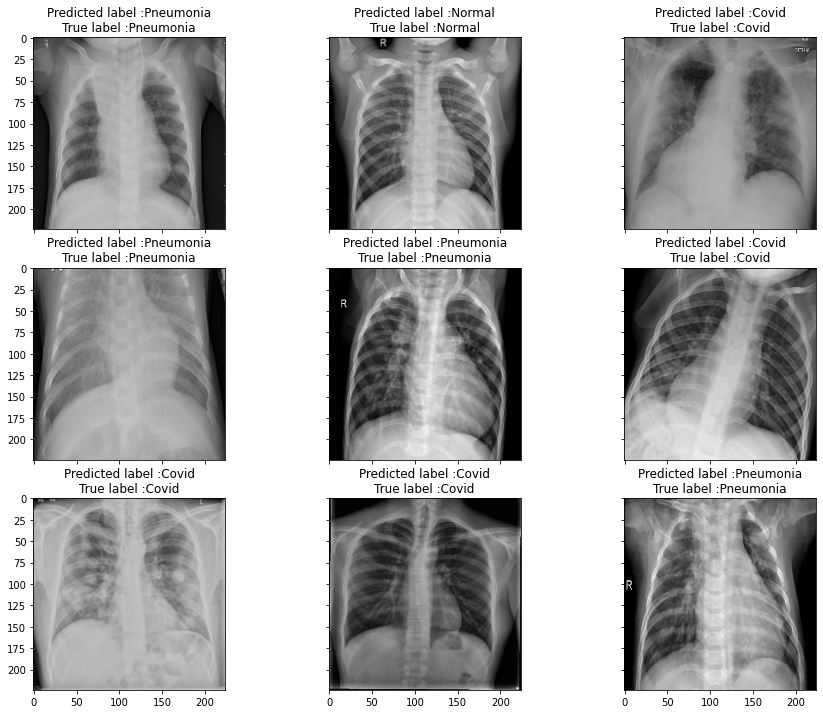

In [17]:
ypred = model.predict(testX)
total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(testY[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')
label= {0: 'Normal', 1: 'Covid', 2: 'Pneumonia'}
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(testX[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(testY[imidx[n]])]))
            n += 1

plt.show()